# Conditional Invertible Neural Networks (cINNs) on BrainScaleS-2

In [1]:
from collections import OrderedDict
from typing import Callable, Union

from time import time
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.optim
import torch.nn as nn
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F

import hxtorch
import _hxtorch
import hxtorch.nn as hxnn

import FrEIA.framework as Ff
import FrEIA.modules as Fm

import quantized_cINN.common as com

##  Generate toy dataset

In order to prove the functioning of the implemented cINN with the limitations accompanying the use of BrainScaleS-2, an example dataset as easy as possible is needed. Here, we generate pictures with the size of four pixels, of which one is light and the other three are dark. The respective label indicates the position of the light pixel. The goal of this exercise is for the network to generate similar pictures having the light pixel in the correct place given a conditional.

In [7]:
class ExampleDataset(torch.utils.data.Dataset):

    def __init__(self, n_samples=100000, img_size=(2, 2), transform=None):
        self.n_samples = n_samples
        self.img_size = img_size
        self.transform = transform
        self.data, self.targets = self._generate_data()

    def _generate_data(self):
        floor = 0.2
        intensity = (0, 1)

        high = self.img_size[0] * self.img_size[1]
        labels = torch.randint(low=0, high=high, size=(self.n_samples, ))
        imgs = floor * torch.rand((self.n_samples, 1, *self.img_size))
        imgs[torch.arange(self.n_samples), :, labels%2, labels//2] += intensity[1] - floor 
        return imgs, labels

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
    
        X = self.data[idx].numpy()
        y = self.targets[idx].reshape(-1).numpy()
        if self.transform:
            X = self.transform(X)
        return X, y

class ExampleData:

    def __init__(self, config: object):
        from torch.utils.data import Dataset, DataLoader, TensorDataset
        import torchvision.transforms as T

        self.c = config

        self.train_data = ExampleDataset(transform=T.ToTensor())
        self.test_data = ExampleDataset(transform=T.ToTensor())

        # Sample a fixed batch of 1024 validation examples
        self.val_x, self.val_l = zip(*list(self.train_data[i] for i in range(1024)))
        self.val_x = torch.stack(self.val_x, 0).to(config.device)
        self.val_l = torch.LongTensor(self.val_l).to(config.device)

        # Exclude the validation batch from the training data
        self.train_data.data = self.train_data.data[1024:]
        self.train_data.targets = self.train_data.targets[1024:]

        ## Add the noise-augmentation to the (non-validation) training data:
        #augm_func = lambda x: x + self.c.add_image_noise * torch.randn_like(x)
        #self.train_data.transform = T.Compose([self.train_data.transform, augm_func])

        self.train_loader = DataLoader(self.train_data,
                                       batch_size=self.c.batch_size,
                                       shuffle=True,
                                       num_workers=self.c.n_workers,
                                       pin_memory=True, drop_last=True)
        self.test_loader = DataLoader(self.test_data,
                                      batch_size=self.c.batch_size,
                                      shuffle=False,
                                      num_workers=self.c.n_workers,
                                      pin_memory=True, drop_last=True)

## Configuaration

In [3]:
class CONFIG(com.baseCONFIG):
    """
    Namspace for configuration
    """
    # Data
    data_mean = None
    data_std = None
    add_image_noise = None

    img_size = (2, 2)
    device = "cpu"
    n_workers = 8

    # Hardware simulation
    mock = False

    # Training
    lr = 1e-3
    batch_size = 256
    weight_decay = 1e-5
    gamma = 0.1
    milestones = [20, 40]
    betas = (0.9, 0.999)

    n_epochs = 5

    init_scale = 0.03
    pre_low_lr = 0
    
    clip_grad_norm = 100.0

    # Architecture
    n_blocks = 8
    internal_width = 16
    clamping = 1.
    fc_dropout = 0.0

    # Logging/preview
    loss_names = ['L']
    preview_upscale = 3                         # Scale up the images for preview
    sampling_temperature = 0.8                  # Sample at a reduced temperature for the preview
    progress_bar = True                         # Show a progress bar of each epoch
    eval_steps_interploation = 12
    eval_seeds_interpolation  = (51, 89)

    # Validation
    pca_weights = [
        [(0,0.55)],
        [(1,0.1), (3, 0.4), (4, 0.5)],
        [(2,0.33), (3, 0.33), (1, -0.33)]]
    pca_gridsize = 10
    pca_extent = 8.


    # Paths
    mnist_data = "../mnist_data"
    save_dir = "out/hx_mock/"

    load_file = "out/hx_mock/hx_mock_example_checkpoint.pt"
    filename = "out/hx_mock/hx_mock_example_cinn.pt"

    # Checkpoints
    checkpoint_save_interval =  50
    checkpoint_save_overwrite = True
    checkpoint_on_error = True

## Model

### Modules 

The input and output of the hardware needs to be approriately scaled, since its range is limited.

In [4]:
from torch.nn.parameter import Parameter

class LinearScaling(nn.Module):

    def __init__(self, weight: float=1., bias: float=0.,
                 outrange=None, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(LinearScaling, self).__init__()

        self.weight = Parameter(torch.tensor(weight), requires_grad=True)
        self.bias = Parameter(torch.tensor(bias), requires_grad=True)
        self.outrange = outrange

    def forward(self, x):
        x = x * self.weight + self.bias
        if self.outrange:
            x = x.clamp(*self.outrange)
        return x

class MinMaxScaling(nn.Module):

    def __init__(self, outrange, per_feature=False, size=None):
        #assert (per_feature and not size) "If you want per_feature "
        super(MinMaxScaling, self).__init__()
        if size:
            self.weight = torch.ones(size)
            self.bias = torch.zeros(size)
            self.per_feature = per_feature
        else:
            self.weight = torch.ones(1)
            self.bias = torch.zeros(1)
            self.per_feature = False
        #self.register_parameter("factor__", None)
        #self.register_parameter("bias__", None)

        self.outrange = outrange
        self.in_min = None
        self.in_max = None

    def forward(self, x):
        if self.training:
            if self.per_feature:
                self.in_min = torch.min(x, axis=0)[0]
                self.in_max = torch.max(x, axis=0)[0]
            else:
                self.in_min = torch.tensor([torch.min(x)])
                self.in_max = torch.tensor([torch.max(x)])

        _norm = self.in_max - self.in_min
        self.weight = (self.outrange[1] - self.outrange[0]) / _norm
        self.bias = self.outrange[1] - self.weight * self.in_max
        return self.weight * x + self.bias     
        
        
class Scale(nn.Module):
    def __init__(self, scale=1):
        super(Scale, self).__init__()
        self.scale = scale
        
    def forward(self, x):
        x = x * self.scale
        return x
    
class DynamicScaling(nn.Module):
    r"""Applies a linear scaling to the incoming data: :math:`y = x*w + b`
    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.
    Args:
        features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``
    Shape:
        - Input: :math:`(N, *, H)` where :math:`*` means any number of
          additional dimensions and :math:`H = \text{features}`.
        - Output: :math:`(N, *, H)`.
    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`
    """
    __constants__ = ['features']
    features: int
    weight: torch.Tensor

    def __init__(self, features: int, bias: bool = True,
                device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(DynamicScaling, self).__init__()
        self.features = features

        self.weight = Parameter(torch.empty(features, **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters_static()

    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(torch.diag(self.weight), a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(torch.diag(self.weight))
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)
            
    def reset_parameters_static(self) -> None:
        nn.init._no_grad_fill_(self.weight, 0.03)
        nn.init.zeros_(self.bias)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(input, torch.diag(self.weight), self.bias)

    def extra_repr(self) -> str:
        return 'features={}, bias={}'.format(
            self.features, self.bias is not None
        )
    
class FixedRangeScaling(nn.Module):
    r"""
    """
    __constants__ = ['features', 'max_out']
    per_feature: bool
    features: int
    max_out: int
    weight: torch.Tensor

    def __init__(self, features: int, max_out: int, per_feature: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FixedRangeScaling, self).__init__()
        self.features = features
        self.max_out = max_out
        self.per_feature = per_feature

        self.weight = Parameter(torch.empty(features, **factory_kwargs),
                                requires_grad=False)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.ones_(self.weight)

    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        if self.training:
            max_abs, _ = torch.max(torch.abs(input_), axis=0)
            if not self.per_feature:
                max_abs.fill_(max_abs.max())
            max_abs[max_abs == 0.] = self.max_out
            with torch.no_grad():
                self.weight.data = self.max_out / max_abs
        res = F.linear(input_, torch.diag(self.weight))
        res[res > 0] = torch.floor(res[res > 0])
        res[res < 0] = torch.ceil(res[res < 0])
        return res
            
    def extra_repr(self) -> str:
        return 'features={}, max_out={}, per_feature={}'.format(
            self.features, self.max_out, self.per_feature
        )

### Network architecture

In [5]:
class EXAMPLEcINN_hx(nn.Module):
    """
    """

    def __init__(self, config: object=CONFIG):
        super().__init__()
        #self.stop = False

        self.c = config

        self.cinn = self.build_inn()

        self.trainable_parameters = []
        for name, param in self.cinn.named_parameters():
            #print(name, (name.split(".")[-2][-2:] == "__"))
            if param.requires_grad and not (name.split(".")[-2][-2:] == "__"):
                #print("accept")
                self.trainable_parameters.append(param)
            continue

        #for p in self.trainable_parameters:
        #    print(p)
        #    p.data = self.c.init_scale * torch.randn_like(p)

        self.cinn.to(self.c.device)

        self.optimizer = torch.optim.Adam(self.trainable_parameters,
                                          lr=self.c.lr,
                                          weight_decay=self.c.weight_decay)
        self.weight_scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer,
                                                                #step_size=1,
                                                                milestones=self.c.milestones,
                                                                gamma=self.c.gamma)

    def build_inn(self):
        
        def scale_input_total(x_in: torch.Tensor) -> torch.Tensor:
            max_abs = torch.max(torch.abs(x_in))
            factor = _hxtorch.constants.input_activation_max / max_abs if max_abs != 0 else 1
            return x_in * factor

        def fc_subnet(ch_in, ch_out):
            net = OrderedDict([
                ("hx_input1", FixedRangeScaling(features=ch_in,
                                                max_out=31,
                                                per_feature=True)),
                ("hx_lin_1", hxnn.Linear(in_features=ch_in,
                                         out_features=self.c.internal_width,
                                         bias=False,
                                         num_sends=2,
                                         wait_between_events=2,
                                         mock=self.c.mock,
                                         signed_input=True,
                                         )),
                ("relu1", hxnn.ConvertingReLU(shift=1,
                                              mock=self.c.mock)),
                ("hx_input2", FixedRangeScaling(features=self.c.internal_width,
                                                max_out=31,
                                                per_feature=True)),
                ("hx_lin_2", hxnn.Linear(in_features=self.c.internal_width,
                                         out_features=ch_out,
                                         bias=False,
                                         num_sends=3,
                                         wait_between_events=2,
                                         mock=self.c.mock,
                                         signed_input=True,
                                         )),
                ("hx_output", DynamicScaling(features=ch_out))
            ])
            return nn.Sequential(net)

        cond = Ff.ConditionNode(4)

        nodes = [Ff.InputNode(1, *self.c.img_size)]
        nodes.append(Ff.Node(nodes[-1], Fm.Flatten, {}))

        for k in range(self.c.n_blocks):
            nodes.append(Ff.Node(nodes[-1], Fm.PermuteRandom,
                                 {"seed": k}))
            nodes.append(Ff.Node(nodes[-1], Fm.GLOWCouplingBlock,
                                 {"subnet_constructor": fc_subnet,
                                  "clamp": 1.},
                                  conditions=cond))

        nodes += [cond, Ff.OutputNode(nodes[-1])]
        return Ff.ReversibleGraphNet(nodes, verbose=False)

    def forward(self, x, l, jac=True):
        return self.cinn(x, c=one_hot(l), jac=jac)

    def reverse_sample(self, z, l, jac=True):
        return self.cinn(z, c=one_hot(l), rev=True, jac=jac)

    def save(self, name):
        save_dict = {"opt": self.optimizer.state_dict(),
                     "net": self.cinn.state_dict(),
                     "lr": self.weight_scheduler.state_dict()}
        torch.save(save_dict, name)

    def load(self, name):
        state_dicts = torch.load(name)
        self.cinn.load_state_dict(state_dicts["net"])
        try:
            self.optimizer.load_state_dict(state_dicts["opt"])
        except ValueError:
            print("Cannot load optimizer for some reason or other")
        try:
            self.weight_scheduler.load_state_dict(state_dicts["lr"])
        except ValueError:
            print("Cannot load optimizer for some reason or other")
            
def one_hot(labels, out=None):
    '''
    Convert LongTensor labels (contains labels 0-9), to a one hot vector.
    Can be done in-place using the out-argument (faster, re-use of GPU memory)
    '''
    if out is None:
        out = torch.zeros(labels.shape[0], 4).to(labels.device)
    else:
        out.zeros_()
    out.scatter_(dim=1, index=labels.view(-1,1), value=1.)
    return out

## Training

In [6]:
config = CONFIG()
if not config.mock:
    hxtorch.init_hardware()

data = ExampleData(config)

model_floating = EXAMPLEcINN_hx(config)
#model_floating.load(config.save_dir + "hx_mock_example_cinn_50epochs_mock.pt")

t_start = time()

model_floating.train()
nll_mean = []

val_losses_means = np.array([])
val_losses = np.array([])


try:
    for i_epoch in range(-config.pre_low_lr, config.n_epochs):
        if i_epoch < 0:
            for param_group in model.optimizer.param_groups:
                param_group['lr'] = config.lr * 2e-2

        for i_batch, (x, l) in enumerate(data.train_loader):

            x, l = x.to(config.device), l.to(config.device)
            z, log_j = model_floating(x, l)

            nll = torch.mean(z**2) / 2 - torch.mean(log_j) / np.prod(config.img_size)
            nll.backward()
            torch.nn.utils.clip_grad_norm_(model_floating.trainable_parameters,
                                           config.clip_grad_norm)

            nll_mean.append(nll.item())

            model_floating.optimizer.step()
            model_floating.optimizer.zero_grad()

            print_interval = 10 if not config.mock else 50
            if not i_batch % print_interval:
                with torch.no_grad():
                    z, log_j = model_floating(data.val_x, data.val_l)
                    nll_val = torch.mean(z**2) / 2 - torch.mean(log_j) / np.prod(config.img_size)

                print('%.3i \t%.5i/%.5i \t%.2f \t%.6f\t%.6f\t%.2e' % (i_epoch,
                                                                i_batch, len(data.train_loader),
                                                                (time() - t_start)/60.,
                                                                np.mean(nll_mean),
                                                                nll_val.item(),
                                                                model_floating.optimizer.param_groups[0]['lr'],
                                                                ), flush=True)
                
                val_losses_means = np.append(val_losses_means, np.mean(nll_mean))
                val_losses = np.append(val_losses, nll_val.item())
                
                nll_mean = []
                
            if (i_batch % config.checkpoint_save_interval) == 0:
                model_floating.save(config.filename + 'floating_checkpoint_%.4i' % (i_batch * (1-config.checkpoint_save_overwrite)))

        model_floating.weight_scheduler.step()

        #if (i_epoch % config.checkpoint_save_interval) == 0:
        #    model_floating.save(config.filename + 'floating_checkpoint_%.4i' % (i_epoch * (1-config.checkpoint_save_overwrite)))

    model_floating.save(config.filename)

except BaseException as b:
    if config.checkpoint_on_error:
        model_floating.save(config.filename + "floating_ABORT")
    raise b

/opt/spack_views/visionary-dls/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


000 	00000/00386 	0.26 	1.068135	0.851725	1.00e-03
000 	00010/00386 	1.18 	0.423112	0.034712	1.00e-03
000 	00020/00386 	2.10 	-0.107234	-0.293509	1.00e-03
000 	00030/00386 	3.02 	-0.412709	-0.559287	1.00e-03
000 	00040/00386 	3.94 	-0.689677	-0.810154	1.00e-03
000 	00050/00386 	4.86 	-0.936307	-1.056160	1.00e-03
000 	00060/00386 	5.77 	-1.131788	-1.186694	1.00e-03
000 	00070/00386 	6.69 	-1.275168	-1.334654	1.00e-03
000 	00080/00386 	7.61 	-1.345150	-1.391723	1.00e-03
000 	00090/00386 	8.53 	-1.408250	-1.451540	1.00e-03
000 	00100/00386 	9.45 	-1.441146	-1.487376	1.00e-03
000 	00110/00386 	10.37 	-1.485944	-1.546785	1.00e-03
000 	00120/00386 	11.29 	-1.516798	-1.545801	1.00e-03
000 	00130/00386 	12.21 	-1.563448	-1.576569	1.00e-03
000 	00140/00386 	13.12 	-1.589134	-1.596376	1.00e-03
000 	00150/00386 	14.04 	-1.604579	-1.619686	1.00e-03
000 	00160/00386 	14.96 	-1.629165	-1.629660	1.00e-03
000 	00170/00386 	15.88 	-1.624033	-1.645641	1.00e-03
000 	00180/00386 	16.80 	-1.644880	-1.67119

003 	00350/00386 	139.14 	-1.931298	-1.923430	1.00e-03
003 	00360/00386 	140.06 	-1.927461	-1.952020	1.00e-03
003 	00370/00386 	140.98 	-1.919500	-1.887288	1.00e-03
003 	00380/00386 	141.90 	-1.906447	-1.942555	1.00e-03
004 	00000/00386 	142.49 	-1.918944	-1.957811	1.00e-03
004 	00010/00386 	143.41 	-1.929285	-1.928326	1.00e-03
004 	00020/00386 	144.34 	-1.918571	-1.931168	1.00e-03
004 	00030/00386 	145.25 	-1.916368	-1.903895	1.00e-03
004 	00040/00386 	146.17 	-1.920843	-1.955951	1.00e-03
004 	00050/00386 	147.09 	-1.929709	-1.945561	1.00e-03
004 	00060/00386 	148.01 	-1.942571	-1.941762	1.00e-03
004 	00070/00386 	148.93 	-1.919461	-1.911211	1.00e-03
004 	00080/00386 	149.85 	-1.921940	-1.926642	1.00e-03
004 	00090/00386 	150.77 	-1.927855	-1.932355	1.00e-03
004 	00100/00386 	151.69 	-1.915111	-1.942052	1.00e-03
004 	00110/00386 	152.61 	-1.938407	-1.941173	1.00e-03
004 	00120/00386 	153.52 	-1.937039	-1.940641	1.00e-03
004 	00130/00386 	154.44 	-1.935758	-1.942324	1.00e-03
004 	00140

In [ ]:
np.savetxt(config.save_dir + "/val_losses_means_50epochs_mock_1epoch_hw_w8mock.txt", val_losses_means)
np.savetxt(config.save_dir + "/val_losses_50epochs_mock_1epoch_hw_w8mock.txt", val_losses)

## Evaluation

In [10]:
load_config = CONFIG
load_model = EXAMPLEcINN_hx(load_config)
load_model.load(load_config.save_dir + "hx_mock_example_cinn.pt")

In [11]:
def show_samples(model, data, config, label):
    '''Produces and shows cINN samples for a given label.'''

    N_samples = 100
    l = torch.LongTensor(N_samples).to(config.device)
    l[:] = label

    z = 1.0 * torch.randn(N_samples, np.prod(config.img_size)).to(config.device)

    with torch.no_grad():
        samples = model.reverse_sample(z, l)[0].cpu().numpy()

    full_image = np.zeros((config.img_size[0]*10, config.img_size[1]*10))

    qwe = []
    for k in range(N_samples):
        i, j = k // 10, k % 10
        full_image[config.img_size[0] * i : config.img_size[1] * (i + 1),
                   config.img_size[0] * j : config.img_size[1] * (j + 1)] = samples[k, 0]
        qwe.append(np.argmax(samples[k, 0]))
    qwe = np.array(qwe)
    print(f"{len(qwe[qwe==0])/len(qwe)}\t{len(qwe[qwe==1])/len(qwe)}\t{len(qwe[qwe==2])/len(qwe)}\t{len(qwe[qwe==3])/len(qwe)}")
        

    full_image = np.clip(full_image, 0, 1)
    plt.figure()
    plt.title(F'Generated digits for c={label}')
    plt.imshow(full_image, vmin=0, vmax=1, cmap='gray')
    plt.savefig(config.save_dir + f"/eval_{label}")

Calibration run - floating model
0.96	0.0	0.0	0.04
0.0	0.98	0.02	0.0
0.0	0.02	0.98	0.0
0.09	0.03	0.0	0.88


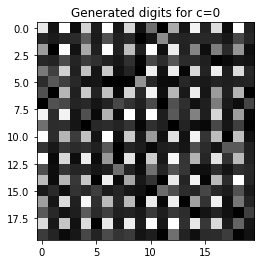

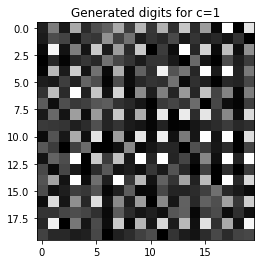

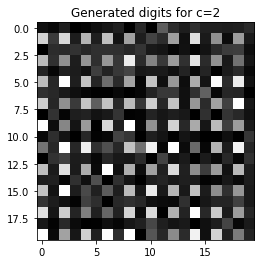

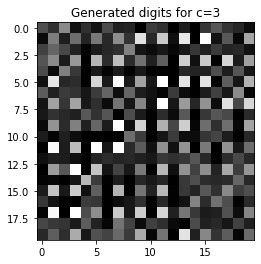

In [12]:
print("Calibration run - floating model")
for k in range(4):
    show_samples(load_model, data, config, k)

In [21]:
max_out = 31
weight = Parameter(torch.empty(16), requires_grad=False)
per_feature = False

#x = torch.Tensor([[31, 0, -31], [-10.5, 0, 7]])
x = torch.randn(3, 10)
x[torch.abs(x) < 0.5] = x[torch.abs(x) < 0.5]
print(x)

max_abs, _ = torch.max(torch.abs(x), axis=0)
if not per_feature:
    max_abs.fill_(max_abs.max())
#print(max_abs)
max_abs[max_abs == 0] = max_out
print(max_abs)
weight = nn.Parameter(max_out / max_abs, requires_grad=False)
print(weight)
out = torch.floor(x * weight)
print(out)
out_diag = torch.floor(F.linear(x, torch.diag(weight)))
#print(out_diag)

print("-------------------")
max_abss = torch.max(torch.abs(x))
factor = _hxtorch.constants.input_activation_max / max_abss if max_abss != 0 else 1
            #factor = torch.Tensor(_hxtorch.constants.input_activation_max).repeat(max_abs.size()) /  \
                #max_abs if max_abs != 0 else 1
res = torch.floor(x * factor)
#print(res)

assert out.all() == out_diag.all()
assert out.all() == res.all()
assert out.all() < 31

tensor([[ 0.0351,  0.6105, -1.5245,  0.9682,  0.7312,  0.7136,  0.4641, -1.3218,
         -0.3367, -0.5885],
        [-1.1072, -1.9708, -0.3163, -0.8902, -0.7194, -0.2035, -0.7731, -1.8471,
          1.0730,  0.6621],
        [ 0.2240,  0.9835, -0.6787,  0.3568, -1.7117,  2.2486,  0.5351, -0.6314,
          1.2296, -0.3926]])
tensor([2.2486, 2.2486, 2.2486, 2.2486, 2.2486, 2.2486, 2.2486, 2.2486, 2.2486,
        2.2486])
Parameter containing:
tensor([13.7864, 13.7864, 13.7864, 13.7864, 13.7864, 13.7864, 13.7864, 13.7864,
        13.7864, 13.7864])
tensor([[  0.,   8., -22.,  13.,  10.,   9.,   6., -19.,  -5.,  -9.],
        [-16., -28.,  -5., -13., -10.,  -3., -11., -26.,  14.,   9.],
        [  3.,  13., -10.,   4., -24.,  31.,   7.,  -9.,  16.,  -6.]])
-------------------
